In [357]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from scipy.stats import entropy
from scipy.stats import mannwhitneyu as mwu
import plotly.graph_objects as go

In [358]:
data_dir = '../Data/Clinical/'
data_dir2 = '../Result/'
out_dir = '../Result/'

# max_css = pd.read_csv( data_dir + "max_css_table.csv")
cl1 = pd.read_csv( data_dir + "clinical_data_1.csv", sep=',')
cl2 = pd.read_csv( data_dir + "clinical_data_2.csv", sep=',')
clinical_data = pd.read_csv( data_dir + "clinical_data.csv", sep=',')
max_css = pd.read_csv(data_dir2 + "max_css_table.csv")

BCRHC01 = pd.read_csv(data_dir2 + 'aa_shannon_BCR_01_HC.csv')
BCRLC01 = pd.read_csv(data_dir2 + 'aa_shannon_BCR_01_LC.csv')
TCR01 = pd.read_csv(data_dir2 + 'aa_shannon_TCR_01.csv')
BCRHC02 = pd.read_csv(data_dir2 + 'aa_shannon_BCR_02_HC.csv')
BCRLC02 = pd.read_csv(data_dir2 + 'aa_shannon_BCR_02_LC.csv')
TCR02 = pd.read_csv(data_dir2 + 'aa_shannon_TCR_02.csv')

all = [BCRHC01, BCRLC01, TCR01, BCRHC02, BCRLC02, TCR02]
only01 = [BCRHC01, BCRLC01, TCR01]
only02 = [BCRHC02, BCRLC02, TCR02] 

BCRHC01.loc[BCRHC01['Time_point'] == 0, 'Time_point'] = 1

sev_dict = max_css['severity'].value_counts().to_dict()

print(sev_dict)
print(max_css.head())
print(BCRHC01.head())

C:\Users\정우빈\AppData\Local\Temp\ipykernel_1124\1197128187.py:7: DtypeWarning: Columns (17,19,21,23,38,69,84,139,154,165,283,289,290,292,294,316) have mixed types. Specify dtype option on import or set low_memory=False.
  cl2 = pd.read_csv( data_dir + "clinical_data_2.csv", sep=',')


{1: 204, 2: 165, 3: 52, 4: 36, 5: 2}
            ID  severity
0  COV-CCO-001         2
1  COV-CCO-002         2
2  COV-CCO-003         2
3  COV-CCO-004         2
4  COV-CCO-006         1
             Sample  Row_number  Total_readcount  Shannon_diversity  \
0  COV-CCO-0411_IGG        2498            19342           6.727983   
1  COV-CCO-0411_IGM        7006            11251           8.179853   
2  COV-CCO-0412_IGG         348             1523           5.104862   
3  COV-CCO-0412_IGM        1183             1850           6.769221   
4  COV-CCO-0413_IGG        2743            12102           6.672048   

       PlnP2  Squared_Shannon  Time_point Type  
0  47.012921        45.265755           1  IGG  
1  69.480620        66.909994           1  IGM  
2  27.682505        26.059611           2  IGG  
3  46.744685        45.822355           2  IGM  
4  47.145421        44.516224           3  IGG  


C:\Users\정우빈\AppData\Local\Temp\ipykernel_1124\1197128187.py:8: DtypeWarning: Columns (98,128) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical_data = pd.read_csv( data_dir + "clinical_data.csv", sep=',')


In [359]:
# cl2.columns 중 start, end로 시작되는 컬럼들을 출력
start = cl2.columns[cl2.columns.str.startswith('M4_X')]
end = cl2.columns[cl2.columns.str.endswith('XRAYT')]
print(start), print(end)

Index(['M4_XRAY', 'M4_XRAYEXP'], dtype='object')
Index(['M1_XRAYT'], dtype='object')


(None, None)

In [360]:
# cl1['PNTTM'] = cl1.groupby('ID').cumcount() + 1
sevcol1 = ['ID', 'PNTTM', 'CMD_CDATE', 'CMD_DATE2', 'CMD_EDATE', 'CMD_COVID19', 'CMD_NPRONG', 'CMD_MASK', 'CMD_HFNC', 'CMD_NIV', 'CMD_IV', 'CMD_ECMO', 'CMD_CRRT', 'CMD_NOGAS', 'CMD_XRAYT', 'CMD_ER'] # not 'CMD_HFNCOC'
cl1 = cl1[sevcol1]

droped = sevcol1[5:]
cl1_any = cl1.drop(['CMD_CDATE', 'CMD_DATE2', 'CMD_EDATE'], axis=1)
# cl1_any = cl1_any.groupby('ID').agg(lambda x: ','.join(x.astype(str).unique()))
# cl1_any = cl1_any.groupby('ID').agg(lambda x: ','.join(x.astype(str)))

def unique_with_change(x):
    result = []
    prev_value = None
    for value in x:
        if value != prev_value:
            result.append(value)
            prev_value = value
    return ','.join(map(str, result))

cl1_any = cl1_any.groupby('ID').agg(lambda x: unique_with_change(x))

def find_max_value(string):
    values = [int(x) for x in string.split(',')]
    max_value = max(values)
    return str(max_value)

def keep_max_value(string):
    max_value = find_max_value(string)
    return ','.join([max_value])

def safe_int(x):
    try:
        return int(float(x))
    except ValueError:
        return None

def remove_specific_values(string):
    values = [safe_int(x) for x in string.split(',') if safe_int(x) not in [66666, 77777, 99999] and safe_int(x) is not None]
    return ','.join(map(str, values))

cl1_any['PNTTM'] = cl1_any['PNTTM'].apply(keep_max_value)
for col in droped:
    cl1_any[col] = cl1_any[col].apply(remove_specific_values)
cl1_any

,PNTTM,CMD_COVID19,CMD_NPRONG,CMD_MASK,CMD_HFNC,CMD_NIV,CMD_IV,CMD_ECMO,CMD_CRRT,CMD_NOGAS,CMD_XRAYT,CMD_ER
ID,,,,,,,,,,,,
COV-CCO-001,11,1,2,2,2,2,2,2,2,2,1,1
COV-CCO-002,10,1,2,2,2,2,2,2,2,2,1,1
COV-CCO-003,9,1,2,2,2,2,2,2,2,2,1,1
COV-CCO-004,16,1,2,2,2,2,2,2,2,2,1,1
COV-CCO-006,12,1,2,2,2,2,2,2,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
COV-SCO-069,31,1,"2,1,2,1,2",2,"2,1,2",2,2,2,2,2,1,1
COV-SCO-070,12,1,2,2,2,2,2,2,2,2,1,1
COV-SCO-071,10,1,"2,2","2,2","2,2","2,2","2,2","2,2","2,2","2,2",1,1


In [361]:
cl1_any['CMD_COVID19'].value_counts()

CMD_COVID19
1      279
2      120
1,1     21
Name: count, dtype: int64

In [362]:
change_cl1 = cl1_any[cl1_any.apply(lambda x: x.astype(str).str.contains(',').any(), axis=1)]

def remove_consecutive_same_values(x):
    values = x.split(',')
    result = [values[i] for i in range(len(values)) if i == 0 or values[i] != values[i-1]]
    return ','.join(result)

change_cl1 = change_cl1.applymap(remove_consecutive_same_values)
change_cl1 = change_cl1[change_cl1.apply(lambda x: x.astype(str).str.contains(',').any(), axis=1)]
display(change_cl1, change_cl1.shape)

,PNTTM,CMD_COVID19,CMD_NPRONG,CMD_MASK,CMD_HFNC,CMD_NIV,CMD_IV,CMD_ECMO,CMD_CRRT,CMD_NOGAS,CMD_XRAYT,CMD_ER
ID,,,,,,,,,,,,
COV-CCO-035,16,1,"2,1,2",2,2,2,2,2,2,2,1,1
COV-CCO-047,22,1,"2,1,2",2,2,2,2,2,2,2,1,1
COV-CCO-071,20,1,"2,1,2",2,2,2,2,2,2,2,1,1
COV-CCO-072,28,1,"2,1,2",2,"1,2",2,2,2,2,2,1,1
COV-CCO-080,17,1,"2,1,2",2,2,2,2,2,2,2,1,1
COV-CCO-096,17,1,"2,1,2",2,2,2,2,2,2,2,1,1
COV-CCO-111,12,1,"1,2,1,2","2,1,2",2,2,2,2,2,2,2,1
COV-CCO-115,20,1,"2,1,2",2,2,2,2,2,2,2,1,1
COV-CCO-123,20,1,"2,1,2",2,2,2,2,2,2,2,1,1


(37, 12)

In [363]:
# cl2['PNTTM'] = cl2.groupby('ID').cumcount() + 1
sevcol2 = ['ID', 'PNTTM','M1_CDATE', 'REG_DATE', 'M3_EDATE', 'M1_COVID19', 'M2_NPRONG', 'M2_MASK',  'M2_HFNC',  'M2_NIV',  'M2_IV', 'M2_ECMO', 'M2_CRRT', 'M2_NOGAS', 'M1_XRAYT', 'M3_ER']
cl2 = cl2[sevcol2]

droped = sevcol2[5:]
cl2_any = cl2.drop(['M1_CDATE', 'REG_DATE', 'M3_EDATE'], axis=1)

cl2_any = cl2_any.groupby('ID').agg(lambda x: unique_with_change(x))

cl2_any['PNTTM'] = cl2_any['PNTTM'].apply(keep_max_value)
for col in droped:
    cl2_any[col] = cl2_any[col].apply(remove_specific_values)

cl2_any.loc[cl2_any['M1_COVID19'] == '', 'M1_COVID19'] = '1'

cl2_any

,PNTTM,M1_COVID19,M2_NPRONG,M2_MASK,M2_HFNC,M2_NIV,M2_IV,M2_ECMO,M2_CRRT,M2_NOGAS,M1_XRAYT,M3_ER
ID,,,,,,,,,,,,
COV-CCO-236,9,1,2,2,2,2,2,2,2,2,1,1
COV-CCO-237,9,1,2,2,2,2,2,2,2,2,2,1
COV-CCO-238,15,1,2,2,2,2,2,2,2,2,2,1
COV-CCO-239,19,1,"2,1,2",2,"2,1,2",2,"2,1",2,2,2,1,1
COV-CCO-240,16,1,"2,2,1,1,2","2,2,2,2","2,2,2,2","2,2,2,2","2,2,2,2","2,2,2,2","2,2,2,2","2,2,2,2",1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
COV-SCO-096,3,1,2,2,2,2,2,2,2,1,,1
COV-SCO-097,3,1,2,2,2,2,2,2,2,1,,1
COV-SCO-098,3,1,"2,2","2,2","2,2","2,2","2,2","2,2","2,2","1,1",,1


In [364]:
cl2_any['M1_COVID19'].value_counts()

M1_COVID19
1    159
2     80
Name: count, dtype: int64

In [365]:
change_cl2 = cl2_any[cl2_any.apply(lambda x: x.astype(str).str.contains(',').any(), axis=1)]
change_cl2 = change_cl2.applymap(remove_consecutive_same_values)
change_cl2 = change_cl2[change_cl2.apply(lambda x: x.astype(str).str.contains(',').any(), axis=1)]
display(change_cl2, change_cl2.shape)

,PNTTM,M1_COVID19,M2_NPRONG,M2_MASK,M2_HFNC,M2_NIV,M2_IV,M2_ECMO,M2_CRRT,M2_NOGAS,M1_XRAYT,M3_ER
ID,,,,,,,,,,,,
COV-CCO-239,19,1,"2,1,2",2,"2,1,2",2,"2,1",2,2,2,1,1
COV-CCO-240,16,1,"2,1,2",2,2,2,2,2,2,2,1,1
COV-CCO-241,11,1,2,2,"1,2",2,"2,1","2,1",2,2,1,1
COV-CCO-243,15,1,"2,1",2,2,2,2,2,2,2,2,1
COV-CCO-249,16,1,"2,1,2",2,2,2,2,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
COV-CCO-373,14,1,2,2,"1,2,1,2",2,"2,1,2",2,2,2,1,1
COV-MCO-006,9,1,"2,1,2",2,"1,2,1",2,2,2,2,2,1,1
COV-MCO-010,16,1,2,2,"1,2",2,"2,1",2,2,2,1,1


(64, 12)

In [366]:
cl1_any.reset_index(inplace=True, drop=False)
cl2_any.reset_index(inplace=True, drop=False)

col_list = ['ID','PNTTM','COVID19','NPRONG','MASK','HFNC','NIV','IV','ECMO','CRRT','NOGAS','XRAYT', 'ER']
cl1_any.columns = col_list
cl2_any.columns = col_list
change_cl = pd.concat([cl1_any, cl2_any], axis=0)
change_cl = change_cl.groupby('ID').agg(lambda x: unique_with_change(x))
change_cl = change_cl.applymap(remove_consecutive_same_values)
change_cl.reset_index(inplace=True, drop=False)
print(change_cl.shape)

(620, 13)


In [367]:
for col in col_list:
    result = change_cl[col].value_counts().get('', 0)
    print(result)

0
0
0
161
161
161
161
161
161
161
161
57
163


In [368]:
for col in col_list[3:13]:
    change_cl.loc[change_cl[col] == '', col] = '2'  # 2 = No disease
change_cl.loc[change_cl['ER'] == '', 'ER'] = '1'    # 1 = Alive / 2 = Dead

change_cl.loc[change_cl['XRAYT'] == '2,', 'XRAYT'] = '2'
    
change_cl['COVID19'].value_counts()

COVID19
1    459
2    161
Name: count, dtype: int64

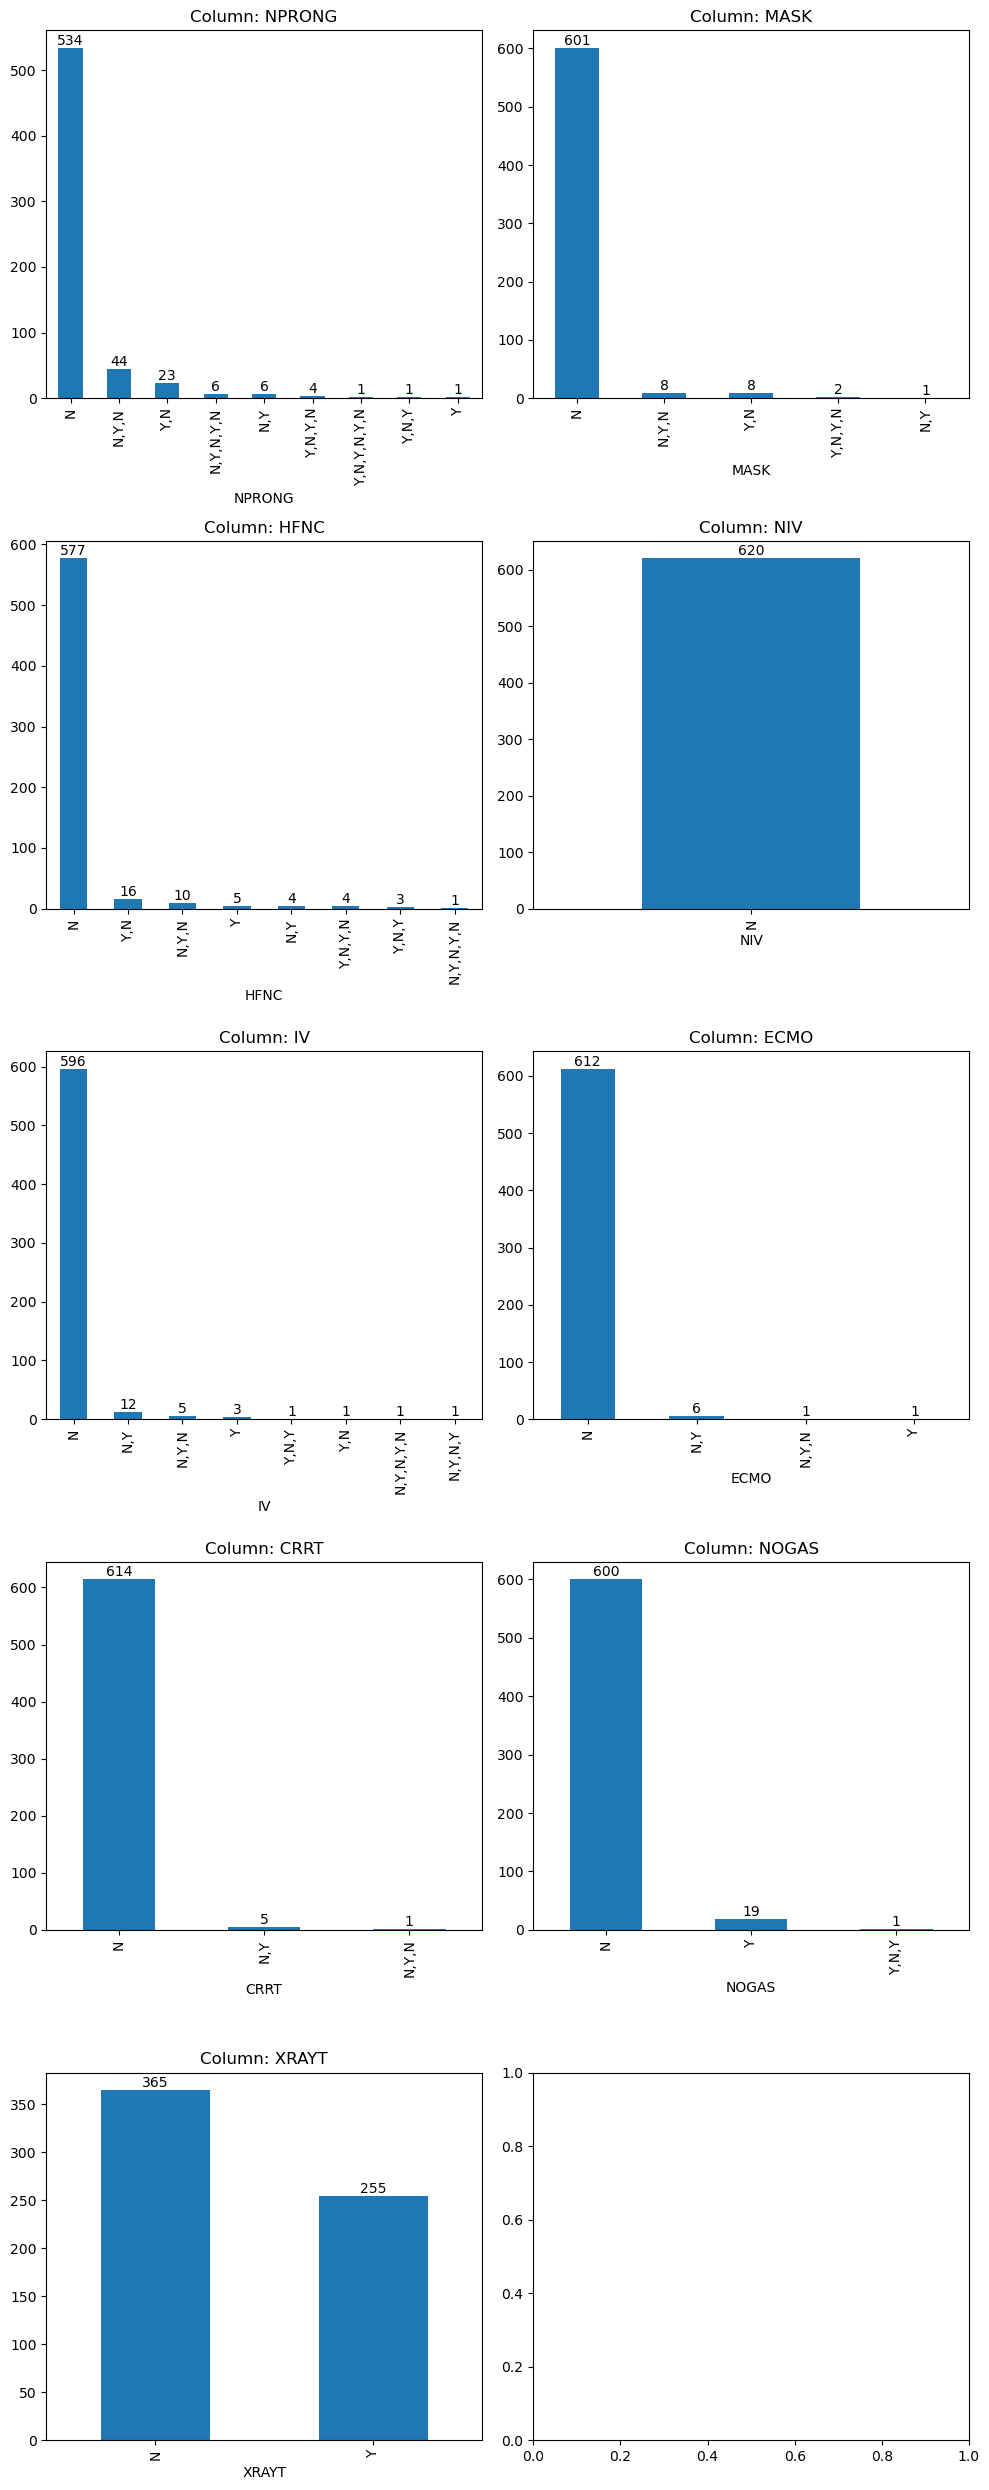

In [369]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(10, 25))

change_cl['ER'] = change_cl['ER'].apply(lambda x: x.replace('1', 'N').replace('2', 'Y'))
for i, col in enumerate(col_list[3:12]):
    change_cl[col] = change_cl[col].astype(str)
    change_cl[col] = change_cl[col].apply(lambda x: x.replace('1', 'Y').replace('2', 'N'))

    ax = axes[i//2, i%2]
    change_cl[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Column: {col}')
    
    for j, v in enumerate(change_cl[col].value_counts()):
        ax.text(j, v, v, ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [370]:
display(cl1[cl1['CMD_ER'] == 2])
display(cl2[cl2['M3_ER'] == 2])
display(change_cl[change_cl['ER'] == 'Y'])
display(max_css[max_css['severity'] == 5])

,ID,PNTTM,CMD_CDATE,CMD_DATE2,CMD_EDATE,CMD_COVID19,CMD_NPRONG,CMD_MASK,CMD_HFNC,CMD_NIV,CMD_IV,CMD_ECMO,CMD_CRRT,CMD_NOGAS,CMD_XRAYT,CMD_ER
2174,COV-CCO-179,10,2021-04-29,2021-05-08,2021-05-08,1.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,2.0
3045,COV-MCO-002,15,2021-04-27,2021-05-20,2021-05-20,1.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,66666.0,2.0


,ID,PNTTM,M1_CDATE,REG_DATE,M3_EDATE,M1_COVID19,M2_NPRONG,M2_MASK,M2_HFNC,M2_NIV,M2_IV,M2_ECMO,M2_CRRT,M2_NOGAS,M1_XRAYT,M3_ER
1109,COV-CCO-336,10,77777,2021-09-01,2021-09-01,77777,77777,77777,77777,77777,77777,77777,77777,77777,77777,2
1392,COV-CCO-362,12,77777,2021-11-16,2021-11-21,77777,77777,77777,77777,77777,77777,77777,77777,77777,77777,2


,ID,PNTTM,COVID19,NPRONG,MASK,HFNC,NIV,IV,ECMO,CRRT,NOGAS,XRAYT,ER
173,COV-CCO-176,18,1,N,N,N,N,N,N,N,N,N,Y
175,COV-CCO-179,10,1,"N,Y,N","N,Y,N","N,Y",N,N,N,N,N,Y,Y
324,COV-CCO-336,11,1,N,N,N,N,Y,N,N,N,Y,Y
344,COV-CCO-362,12,1,N,N,N,N,Y,Y,"N,Y",N,Y,Y
356,COV-CNC-001,"2,6",2,N,N,N,N,N,N,N,N,N,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,COV-CNO-079,1,2,N,N,N,N,N,N,N,N,N,Y
515,COV-CNO-080,1,2,N,N,N,N,N,N,N,N,N,Y
516,COV-CNO-081,1,2,N,N,N,N,N,N,N,N,N,Y
518,COV-MCO-002,16,1,N,N,"Y,N",N,"N,Y",N,"N,Y",N,Y,Y


,ID,severity
175,COV-CCO-179,5
357,COV-MCO-002,5


C:\Users\정우빈\AppData\Local\Temp\ipykernel_1124\2045124744.py:2: DtypeWarning: Columns (17,19,21,23,38,69,84,139,154,165,283,289,290,292,294,316) have mixed types. Specify dtype option on import or set low_memory=False.
  cl2 = pd.read_csv( data_dir + "clinical_data_2.csv", sep=',')


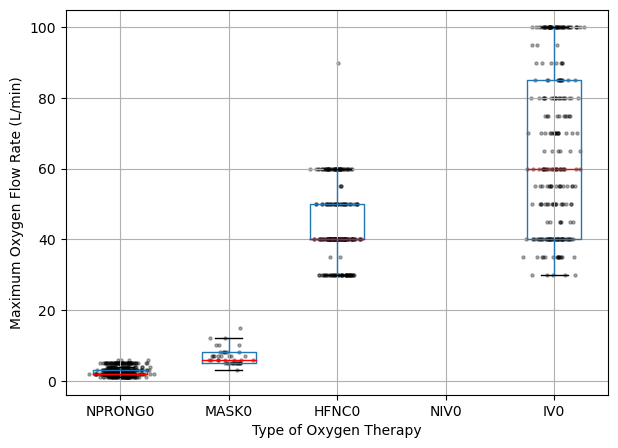

In [371]:
cl1 = pd.read_csv( data_dir + "clinical_data_1.csv", sep=',')
cl2 = pd.read_csv( data_dir + "clinical_data_2.csv", sep=',')

cl1_o2 = cl1[['ID', 'CMD_NPRONGO', 'CMD_MASKO', 'CMD_HFNCO', 'CMD_NIVO', 'CMD_IVO']]
cl2_o2 = cl2[['ID', 'M2_NPRONGO', 'M2_MASKO', 'M2_HFNCO', 'M2_NIVO', 'M2_IVO']]
cl1_o2.columns = ['ID', 'NPRONG0', 'MASK0', 'HFNC0', 'NIV0', 'IV0']
cl2_o2.columns = ['ID', 'NPRONG0', 'MASK0', 'HFNC0', 'NIV0', 'IV0']
cl_all = pd.concat([cl1_o2, cl2_o2], axis=0)
cl_all = cl_all.replace([66666, 77777, 99999], np.nan)

import matplotlib.pyplot as plt

# boxplot 그리기
ax = cl_all.drop(columns='ID').boxplot(showfliers=False, figsize=(7, 5), medianprops=dict(color='red'))

# scatter 추가
for i, col in enumerate(cl_all.drop(columns='ID').columns):
    y = cl_all[col]
    # x = [i + 1] * len(y) 
    x = np.random.normal(i + 1, 0.1, size=len(y))
    ax.scatter(x, y, color='black', alpha=0.3, s=5)
    # plt.yticks(ticks=range(0, int(cl_all.drop(columns='ID').max().max())+10, 10))
    ##축이름
    plt.xlabel('Type of Oxygen Therapy')
    plt.ylabel('Maximum Oxygen Flow Rate (L/min)')

plt.show()


In [372]:
cl_all_id = []
cl1_id = cl1['ID'].unique().tolist()
cl2_id = cl2['ID'].unique().tolist()

for i in cl1_id:
    if i in cl2_id:
        cl_all_id.append(i)

print(len(cl_all_id))

39


In [373]:
### 아래 코드의 작동 예시

data = {
    'ID': ['aaa', 'aaa', 'aaa', 'aaa', 'bbb', 'bbb'],
    'disease1': [2, 99999, 1, 99999, 2, 77777],
    'disease2': [1, 77777, 77777, 99999, 1, 99999]
}
cl1_table = pd.DataFrame(data)

def replace_with_previous(series):
    replaced = True
    while replaced:
        replaced = False
        mask = series.isin([66666, 77777, 99999, np.nan])
        shifted_values = series.shift(1)
        series[mask] = shifted_values[mask]
        replaced = mask.any()
    return series

cl1_table = cl1_table.apply(replace_with_previous)

print(cl1_table)

    ID  disease1  disease2
0  aaa         2         1
1  aaa         2         1
2  aaa         1         1
3  aaa         1         1
4  bbb         2         1
5  bbb         2         1


In [374]:
sevcol1 = [x for x in sevcol1 if x not in ['CMD_CDATE', 'CMD_DATE2', 'CMD_EDATE']]
sevcol2 = [x for x in sevcol2 if x not in ['M1_CDATE', 'REG_DATE', 'M3_EDATE']]
cl1_table = cl1[sevcol1]
cl2_table = cl2[sevcol2]
cl1_table = cl1_table[cl1_table['ID'].isin(cl_all_id) == False]
cl1_table.columns = col_list
cl2_table.columns = col_list
cl_all = pd.concat([cl1_table, cl2_table], axis=0)

cl_all[cl_all['PNTTM']==1]['COVID19'].value_counts()

# 확진(COVID19 양성 : 1) = 459 명 (CCO, SCO, MCO)   PNTTM==1 기준 COVID19==1 : 297      (+162 필요 (127+26+6+2+1=162))
# 정상(COVID19 음성 : 2) = 161 명 (CNC, CNO)        PNTTM==1 기준 COVID19==2 : 87       (+74  필요 (54+20=74))

# cl_all[(cl_all['COVID19']==77777) & (cl_all['PNTTM'] == 1)]['ID'].apply(lambda x: x[4:7]).value_counts()       # CCO 127, SCO 26, MCO 6
# cl_all[(cl_all['COVID19']==99999) & (cl_all['PNTTM'] == 1)]['ID'].apply(lambda x: x[4:7]).value_counts()       # CNC 20
# cl_all[(pd.isna(cl_all['COVID19']))& (cl_all['PNTTM'] == 1)]['ID'].apply(lambda x: x[4:7]).value_counts()      # CNO 54, SCO 2, CCO 1

COVID19
1.0        297
77777.0    159
2.0         87
99999.0     20
Name: count, dtype: int64

In [375]:
cl_mod = cl_all.copy()
# cl_all['COVID19'] = cl_all['COVID19'].astype(str)

cl_mod.loc[(cl_all['PNTTM'] == 1) & (cl_all['COVID19'] == 77777), 'COVID19'] = 1
cl_mod.loc[(cl_all['PNTTM'] == 1) & (cl_all['COVID19'] == 99999), 'COVID19'] = 2

con_01 = cl_all['ID'].str.startswith('COV-SCO|COV-CCO|COV-MCO')
con_02 = cl_all['ID'].str.startswith('COV-CNC|COV-CNO')
con_03 = cl_all['PNTTM'] == 1
con_04 = pd.isna(cl_all['COVID19'])

cl_mod.loc[con_01 & con_03 & con_04, 'COVID19'] = 1
cl_mod.loc[con_02 & con_03 & con_04, 'COVID19'] = 2

cl_mod.loc[(cl_all['PNTTM'] == 1) & 
                ((cl_all['ER'] == 66666) | 
                 (cl_all['ER'] == 77777) | 
                 (cl_all['ER'] == 99999) | 
                 pd.isna(cl_all['ER'])), 'ER'] = 1

#####################################################
        
def replace_with_previous(series):
    prev_mask = None  
    while True:
        mask = series.isin([66666, 77777, 99999, np.nan])
        if prev_mask is not None and (prev_mask == mask).all():
            break  
        shifted_values = series.shift(1)
        series[mask] = shifted_values[mask]
        prev_mask = mask
    return series

cl_mod = cl_mod.apply(replace_with_previous)

#####################################################

cl_mod[cl_mod['PNTTM']==1]['COVID19'].value_counts()

######################################################

# COVID19 / 양성(확진) = 1 / 음성(미확진) = 2
# NPRONG~CRRT / 사용 = 1 / 미사용 = 2
# XRAYT / 이상소견 = 1 / 정상소견 = 2
# ER / 생존 = 1 / 사망 = 2

COVID19
1.0    459
2.0    161
Name: count, dtype: int64

In [376]:
cl_mod.isnull().sum()

ID         0
PNTTM      0
COVID19    0
NPRONG     0
MASK       0
HFNC       0
NIV        0
IV         0
ECMO       0
CRRT       0
NOGAS      0
XRAYT      0
ER         0
dtype: int64

In [377]:
cl_mod['ER'].value_counts(), cl_mod[cl_mod['ER'] == 2]['ID'].unique()

(ER
 1.0    5892
 2.0       6
 Name: count, dtype: int64,
 array(['COV-CCO-179', 'COV-MCO-002', 'COV-CCO-336', 'COV-CCO-362'],
       dtype=object))

In [384]:
cl_mod['severity'] = 0

In [386]:
cl_mod['severity'] = 0

for i, row in cl_mod.iterrows():
    if row['ER'] == 2:
        cl_mod.loc[i, 'severity'] = 5
    else:
        if row['COVID19'] == 1:
            if row['XRAYT'] == 1:
                if (row['NPRONG'] == 1 or row['MASK'] == 1):
                    cl_mod.loc[i, 'severity'] = 3
                elif (row['HFNC'] == 1 or row['NIV'] == 1 or row['IV'] == 1):
                    cl_mod.loc[i, 'severity'] = 4
                else:
                    cl_mod.loc[i, 'severity'] = 2
            else:
                cl_mod.loc[i, 'severity'] = 1
        else:
            cl_mod.loc[i, 'severity'] = 0

cl_mod[cl_mod['PNTTM'] == 1]['severity'].value_counts()        

severity
0    192
1    166
2    147
4     66
3     49
Name: count, dtype: int64

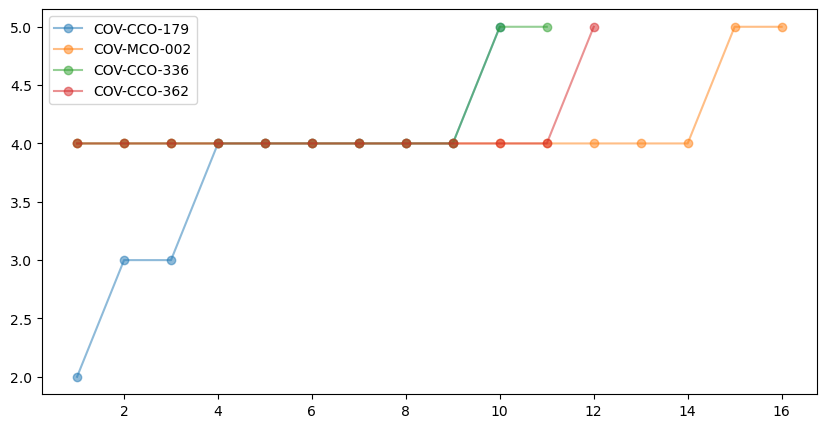

In [389]:
dead_list = cl_mod[(cl_mod['ER'] == 2)]['ID'].unique()

### dead_list에 있는 ID의 환자의 PNTTM 별 severity변화 그래프로 작성

plt.figure(figsize=(10, 5))
for i in dead_list:
    temp = cl_mod[cl_mod['ID'] == i]
    plt.plot(temp['PNTTM'], temp['severity'], label=i, alpha=0.5, marker='o')
plt.legend()
plt.show()


In [380]:
severity_at_pnttm1 = cl_mod[cl_mod['PNTTM'] == 1].groupby('ID')['severity'].mean()
severity_init_dict = severity_at_pnttm1.to_dict()
cl_mod['severity_init'] = cl_mod['ID'].map(severity_init_dict)
print(severity_at_pnttm1.value_counts())

severity
0.0    192
1.0    166
2.0    147
4.0     66
3.0     49
Name: count, dtype: int64


In [381]:
cl_max = cl_mod.loc[cl_mod.groupby('ID')['PNTTM'].idxmax()]
cl_max = cl_max.drop_duplicates('ID', keep='first')
cl_max['severity'].value_counts()

severity
0    192
1    169
2    156
4     69
3     30
5      4
Name: count, dtype: int64

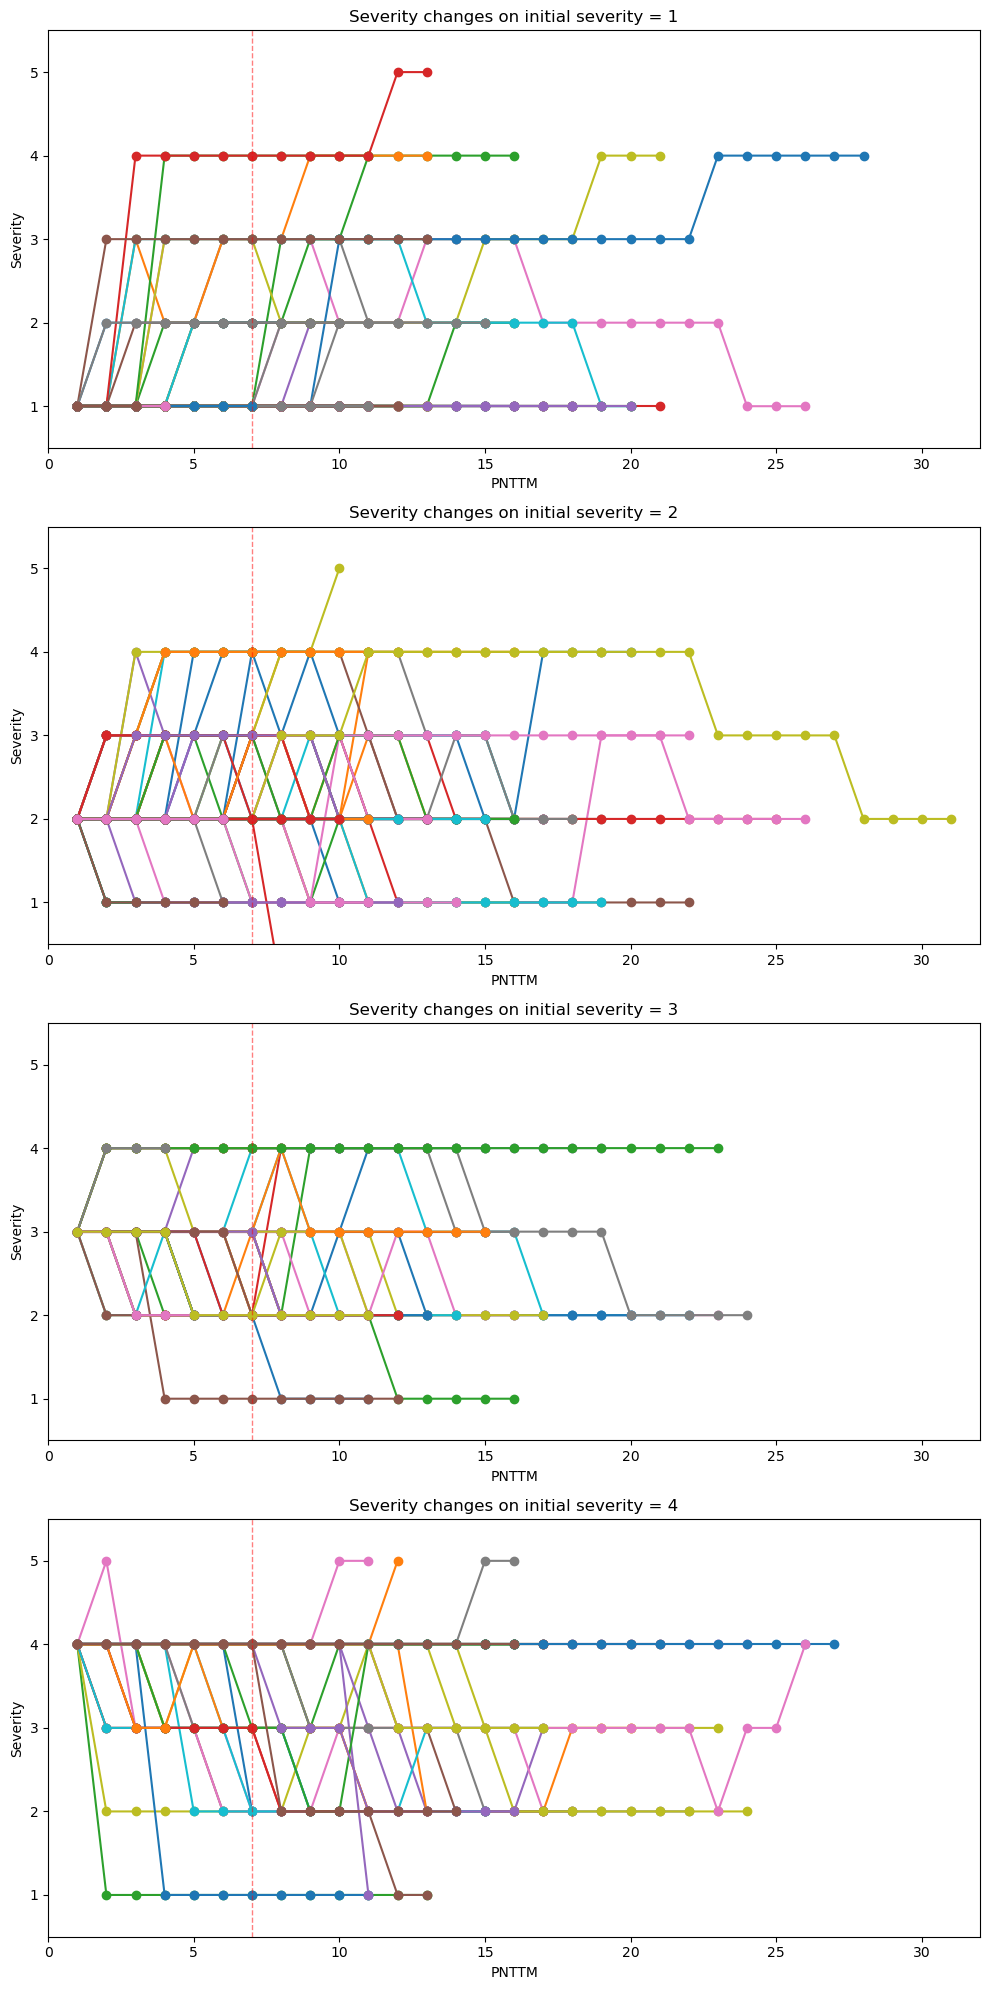

In [382]:
cl_all1 = cl_mod[cl_mod['severity_init'] == 1]
cl_all2 = cl_mod[cl_mod['severity_init'] == 2]
cl_all3 = cl_mod[cl_mod['severity_init'] == 3]
cl_all4 = cl_mod[cl_mod['severity_init'] == 4]

cl_all_list = [cl_all1, cl_all2, cl_all3, cl_all4]

fig, ax = plt.subplots(4, 1, figsize=(10, 20))

for i, df in enumerate(cl_all_list, start=1):
    ax[i-1].set_title(f'Severity changes on initial severity = {i}')
    for id_, group in df.groupby('ID'):
        ax[i-1].plot(group['PNTTM'], group['severity'], marker='o', label=id_)
    ax[i-1].set_xlabel('PNTTM')
    ax[i-1].set_ylabel('Severity')

for i in range(4):
    ax[i].set_ylim(0.5, 5.5)
    ax[i].set_xlim(0, 32)
    ax[i].axvline(x=7, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()    

In [383]:
cl_mod[cl_mod['severity'] == 5]

,ID,PNTTM,COVID19,NPRONG,MASK,HFNC,NIV,IV,ECMO,CRRT,NOGAS,XRAYT,ER,severity,severity_init
1109,COV-CCO-088,12,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,5,1.0
1110,COV-CCO-088,13,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,5,1.0
1392,COV-CCO-113,2,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,5,4.0
2174,COV-CCO-179,10,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,5,2.0
3045,COV-MCO-002,15,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,5,4.0
3046,COV-MCO-002,16,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,5,4.0
1109,COV-CCO-336,10,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,5,4.0
1110,COV-CCO-336,11,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,5,4.0
1392,COV-CCO-362,12,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,5,4.0
